In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime, time, json, requests, pprint, copy
from argovisHelpers import helpers as avh

def polygon_lon_lat(polygon_str):
    # polygon_str: string value of polygon search parameter, ie "[[lon0,lat0],[lon1,lat1],...,[lon0,lat0]]"
    # convert the polygon shape to lon and lat and save in a dictionary
    polygon_lon_lat_dict = {'lon': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[0::2]], \
                    'lat': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[1::2]]
                   }
    return polygon_lon_lat_dict

def simple_map(longitudes, latitudes, z=None, polygon=None, title='', fig=None, figIndex=None, marker=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal())
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        plt.colorbar(s, pad=0.1)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    if polygon:
        plt.plot(polygon_lon_lat(polygon)['lon'],polygon_lon_lat(polygon)['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':20})

# Exploring Argo BGC with Argovis

## Setup: Register an API key

In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:

 - Visit [https://argovis-keygen.colorado.edu/](https://argovis-keygen.colorado.edu/)
 - Fill out the form under _New Account Registration_
 - An API key will be emailed to you shortly.
 
Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.

Put your API key in the quotes in the variable below before moving on:

In [12]:
API_KEY=''
API_PREFIX = ''

# Downloading and plotting BGC data

Download all the BGC measurements in a region over a timespan, and put them on a map:

In [44]:
polygon = '[[-75,42],[-75,38],[-62,38],[-62,42],[-75,42]]'
params = {
        'startDate': '2021-01-01T00:00:00Z',
        'endDate': '2022-01-01T00:00:00Z',
        'source': 'argo_bgc',
        'polygon': polygon,
        'data': 'all'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

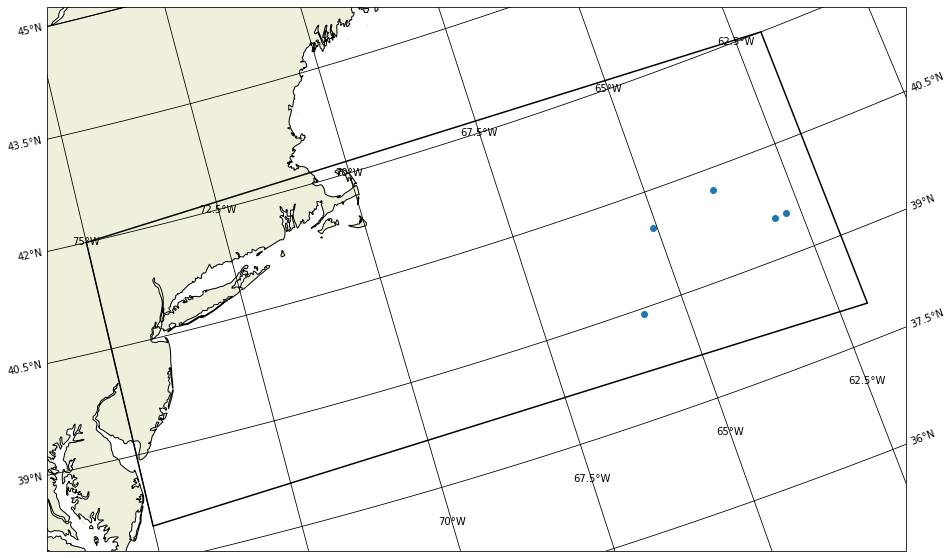

In [46]:
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes,polygon=polygon)

Turn our data into a list of dataframes, and plot with color by QC:

In [54]:
dfs = [pandas.DataFrame.from_records([level for level in profile['data']]) for profile in d]

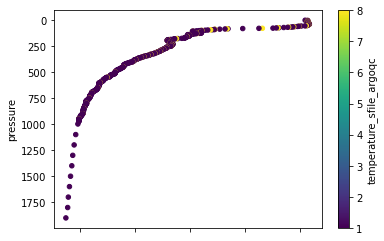

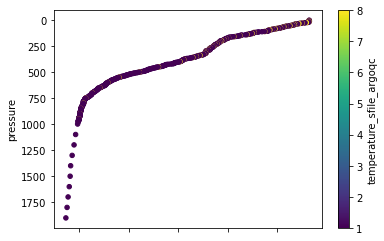

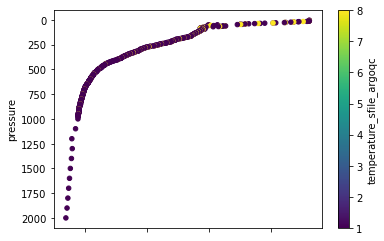

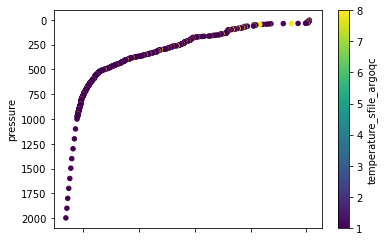

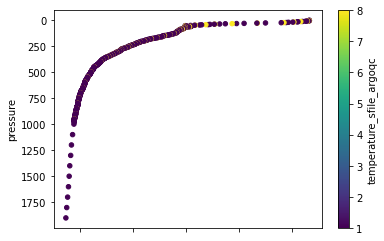

In [63]:
for df in dfs:
    a = df.plot.scatter(x='temperature_sfile', y='pressure', c='temperature_sfile_argoqc', colormap='viridis')
    a.invert_yaxis()

Or, filter by QC before plotting:

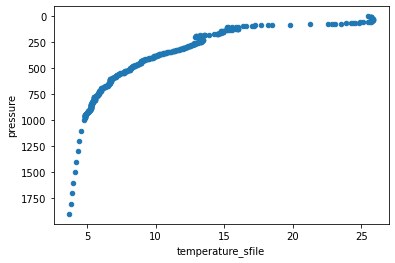

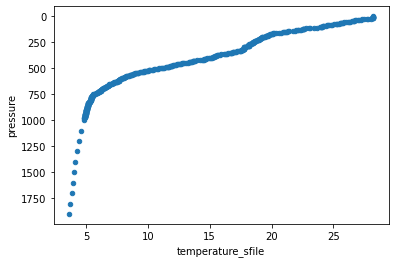

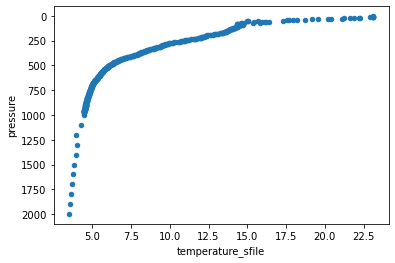

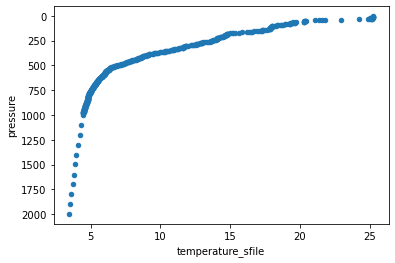

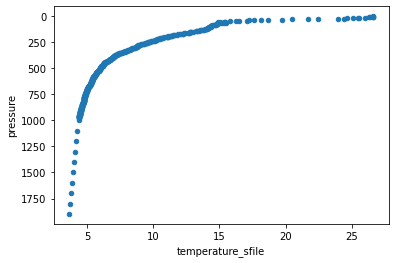

In [72]:
for df in dfs:
    df_qc = df[df['temperature_sfile_argoqc'] == 1]
    a = df_qc.plot.scatter(x='temperature_sfile', y='pressure')
    a.invert_yaxis()

Plot one variable against another:

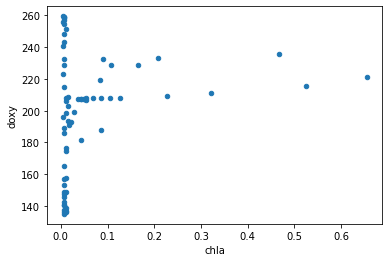

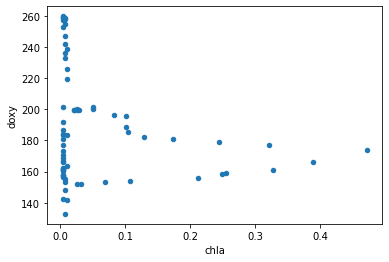

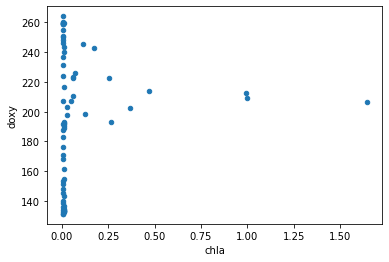

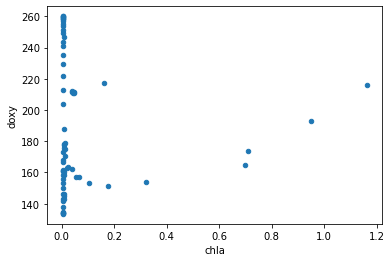

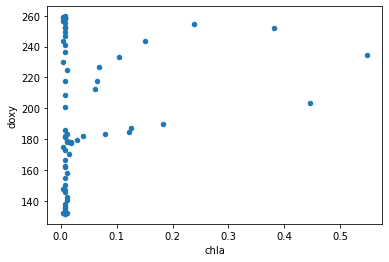

In [75]:
for df in dfs:
    a = df.plot.scatter(x='chla', y='doxy')

List all BGC platforms, with some summary statistics:

In [78]:
bgc = requests.get('https://argovis-api.colorado.edu/argo/bgc').json()
print(bgc)

[{'_id': 'argo_bgc', 'summary': [{'_id': '2903613', 'n': 151, 'mostrecent': '2022-11-08T09:24:20.999Z'}, {'_id': '5904107', 'n': 293, 'mostrecent': '2017-09-08T22:44:21.002Z'}, {'_id': '2902160', 'n': 234, 'mostrecent': '2018-01-31T14:17:23.999Z'}, {'_id': '6902979', 'n': 80, 'mostrecent': '2022-11-01T05:55:59.999Z'}, {'_id': '2900606', 'n': 16, 'mostrecent': '2006-10-04T12:07:31.000Z'}, {'_id': '5906624', 'n': 147, 'mostrecent': '2022-11-06T18:38:07.000Z'}, {'_id': '3900727', 'n': 309, 'mostrecent': '2015-04-09T00:43:50.000Z'}, {'_id': '2901554', 'n': 415, 'mostrecent': '2015-05-20T03:11:02.000Z'}, {'_id': '6904115', 'n': 70, 'mostrecent': '2022-08-24T11:22:00.000Z'}, {'_id': '6903153', 'n': 194, 'mostrecent': '2018-03-15T05:47:00.000Z'}, {'_id': '5906218', 'n': 95, 'mostrecent': '2022-11-05T23:57:18.002Z'}, {'_id': '4901779', 'n': 198, 'mostrecent': '2021-05-22T13:42:00.000Z'}, {'_id': '5904027', 'n': 263, 'mostrecent': '2016-08-21T13:50:17.001Z'}, {'_id': '6900875', 'n': 120, 'mostr

Plot map of all bgc platforms (notes asked for 'color coded by WMO' - not sure this makes sense, in a 10 day span, which is all that's reasonable for a global plot, these colors will all just be different, which doesn't really add anything):

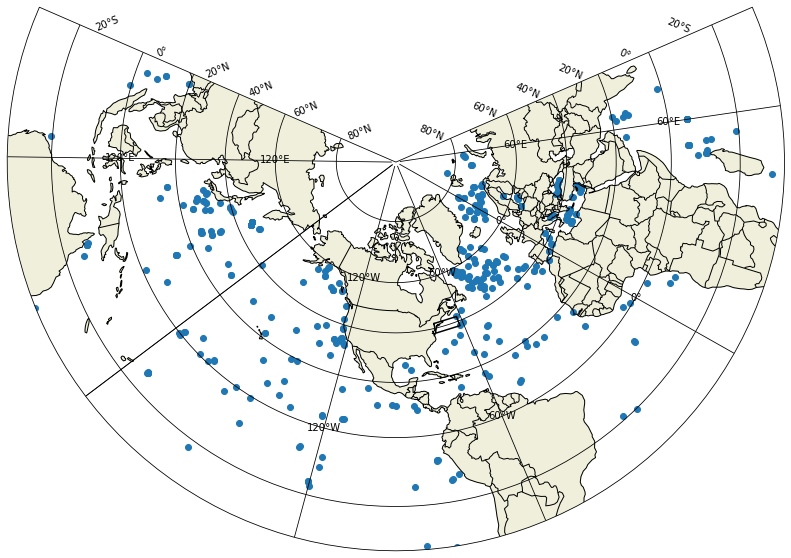

In [86]:
params = {
        'startDate': '2022-10-31T00:00:00Z',
        'endDate': '2022-11-11T00:00:00Z',
        'source': 'argo_bgc',
        'compression': 'array'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes,polygon=polygon)

Query platform and plot data for variable of interest
Include shaded plots (time vs pressure) too (after interpolation on regular vertical grid)
TBD

Query what variables are available for a certain platform

In [106]:
platform = '2903613'

params = {
       'platform': platform
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [111]:
variables = set({})
for i in range(len(d)):
    if 'data_keys' in d[i]:
        variables.update(d[i]['data_keys'])
print(variables)

{'doxy_argoqc', 'salinity_argoqc', 'salinity_sfile_argoqc', 'doxy', 'temperature', 'pressure', 'temperature_argoqc', 'salinity', 'pressure_argoqc', 'temperature_sfile_argoqc', 'salinity_sfile', 'temperature_sfile'}


Co-location example with GO-SHIP data (and if possible other data, e.g. bgc changes with TC passage)